<a href="https://colab.research.google.com/github/permilia9060/MusicEffects/blob/main/Copy_of_Music_effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Music and Mental Condition**
Music has long been recognized for its therapeutic effects, with a profound ability to influence our mood and mental state. In this project, we explore a dataset from Kaggle to understand how music therapy affects various mental health conditions. By leveraging data science techniques, we aim to uncover patterns and insights that reveal the relationship between music and mental well-being. This analysis not only provides a scientific basis for the benefits of music therapy but also helps in identifying key factors that contribute to its effectiveness. Our approach involves cleaning and preprocessing the data, establishing a baseline, and building multiple machine learning models to predict the impact of music on mental health. We compare these models to determine the most effective one and conclude with an analysis of the findings.

In [ ]:
%%capture
!pip install category_encoders==2.*
!pip install ydata_profiling

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from google.colab import files

In [ ]:
# Upload the dataset
uploaded = files.upload()

Saving mxmh_survey_results.csv to mxmh_survey_results.csv


In [ ]:
# Read in data
df = pd.read_csv("mxmh_survey_results.csv")

In [ ]:
# Profile report for initial overview
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="MXMH Survey Results Profiling Report")
profile.to_notebook_iframe()

In [ ]:
# Drop irrelevant columns
df.drop(['Timestamp', 'Permissions'], axis=1, inplace=True)

In [ ]:
# Separate numeric and categorical columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

In [ ]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

In [ ]:
# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Apply the transformations to the data
df_imputed = pd.DataFrame(preprocessor.fit_transform(df), columns=numeric_features.append(categorical_features))

In [ ]:
# Remove outliers
age_index = df_imputed[(df_imputed['Age'] > 70)].index
df_imputed = df_imputed.drop(age_index, axis=0)

In [ ]:
# Check the first few rows of the cleaned dataset
df_imputed.head()

,Age,Hours per day,BPM,Anxiety,Depression,Insomnia,OCD,Primary streaming service,While working,Instrumentalist,...,Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Music effects
0,18.0,3.0,156.0,3.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,63.0,1.5,119.0,7.0,2.0,2.0,1.0,2.0,1.0,2.0,...,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0
2,18.0,4.0,132.0,7.0,7.0,10.0,2.0,1.0,2.0,2.0,...,1.0,3.0,2.0,2.0,3.0,2.0,2.0,3.0,3.0,2.0
3,61.0,2.5,84.0,9.0,7.0,3.0,3.0,3.0,1.0,2.0,...,3.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,4.0,1.0
4,18.0,4.0,107.0,7.0,2.0,5.0,9.0,1.0,1.0,2.0,...,1.0,2.0,2.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0


In [ ]:
# I. Split Data
target = 'Music effects'
y = df_imputed[target]
X = df_imputed.drop(columns=target)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [ ]:
# II. Establish Baseline# II. Establish Baseline
print('Baseline Accuracy: ', y_train.value_counts(normalize=True).max())

Baseline Accuracy:  0.7534246575342466


In [ ]:
# III. Build Models

In [ ]:
# First Model: Decision Trees
model_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=5, random_state=42)
)
model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

In [ ]:
# Check Metrics of Decision Tree
print("TREE: Training Accuracy: ", model_dt.score(X_train, y_train))
print("TREE: Validation Accuracy: ", model_dt.score(X_val, y_val))

TREE: Training Accuracy:  0.809931506849315
TREE: Validation Accuracy:  0.6575342465753424


/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:366: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


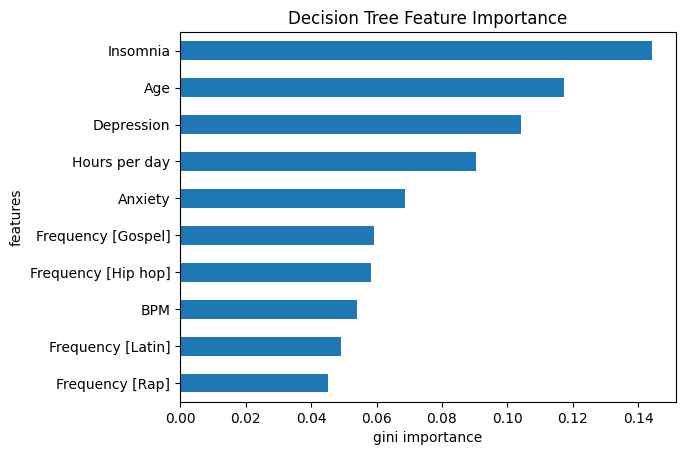

In [ ]:
# Feature Importance for Decision Tree
features = model_dt.named_steps["ordinalencoder"].get_feature_names()
gini = model_dt.named_steps["decisiontreeclassifier"].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind="barh")
plt.ylabel("features")
plt.xlabel("gini importance")
plt.title("Decision Tree Feature Importance")
plt.show()

In [ ]:
# Second Model: Random Forest
model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_jobs=-1, max_depth=5, n_estimators=100, random_state=42)
)
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_jobs=-1,
                                        random_state=42))])

In [ ]:
print("FOREST: Training Accuracy: ", model_rf.score(X_train, y_train))
print("FOREST: Validation Accuracy: ", model_rf.score(X_val, y_val))

FOREST: Training Accuracy:  0.773972602739726
FOREST: Validation Accuracy:  0.726027397260274


/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:366: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


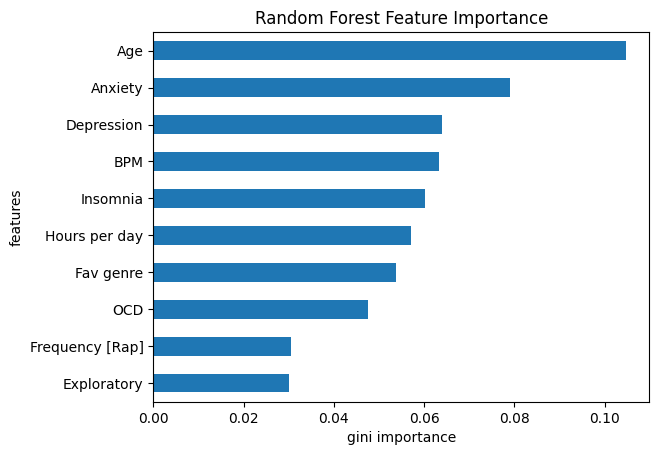

In [ ]:
features = model_rf.named_steps["ordinalencoder"].get_feature_names()
gini = model_rf.named_steps["randomforestclassifier"].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind="barh")
plt.ylabel("features")
plt.xlabel("gini importance")
plt.title("Random Forest Feature Importance")
plt.show()

In [ ]:
# Cross Validation for Random Forest
clf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

param_grid = {
    "randomforestclassifier__max_depth": range(5, 20, 1),
    "randomforestclassifier__n_estimators": range(25, 125, 10)
}

model_rf_gs = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)
model_rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 20),
                         'randomforestclassifier__n_estimators': range(25, 125, 10)},
             verbose=1)

In [ ]:
print("Best Parameters: ", model_rf_gs.best_params_)
print("Best Cross-Validation Score: ", model_rf_gs.best_score_)

Best Parameters:  {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 95}
Best Cross-Validation Score:  0.7568670792808724


In [ ]:
# Third Model: Logistic Regression
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression()
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
# Check Metrics for Logistic Regression
print('Baseline Accuracy: ', y_train.value_counts(normalize=True).max())
print("LOGREG: Training Accuracy: ", model_lr.score(X_train, y_train))
print("LOGREG: Validation Accuracy: ", model_lr.score(X_val, y_val))

Baseline Accuracy:  0.7534246575342466
LOGREG: Training Accuracy:  0.7568493150684932
LOGREG: Validation Accuracy:  0.7191780821917808


In [ ]:
# IV. Communicate Results

In [ ]:
# Compare Models
print("Decision Tree: Training Accuracy: ", model_dt.score(X_train, y_train))
print("Decision Tree: Validation Accuracy: ", model_dt.score(X_val, y_val))
print("Random Forest: Training Accuracy: ", model_rf.score(X_train, y_train))
print("Random Forest: Validation Accuracy: ", model_rf.score(X_val, y_val))
print("Logistic Regression: Training Accuracy: ", model_lr.score(X_train, y_train))
print("Logistic Regression: Validation Accuracy: ", model_lr.score(X_val, y_val))

Decision Tree: Training Accuracy:  0.809931506849315
Decision Tree: Validation Accuracy:  0.6575342465753424
Random Forest: Training Accuracy:  0.773972602739726
Random Forest: Validation Accuracy:  0.726027397260274
Logistic Regression: Training Accuracy:  0.7568493150684932
Logistic Regression: Validation Accuracy:  0.7191780821917808


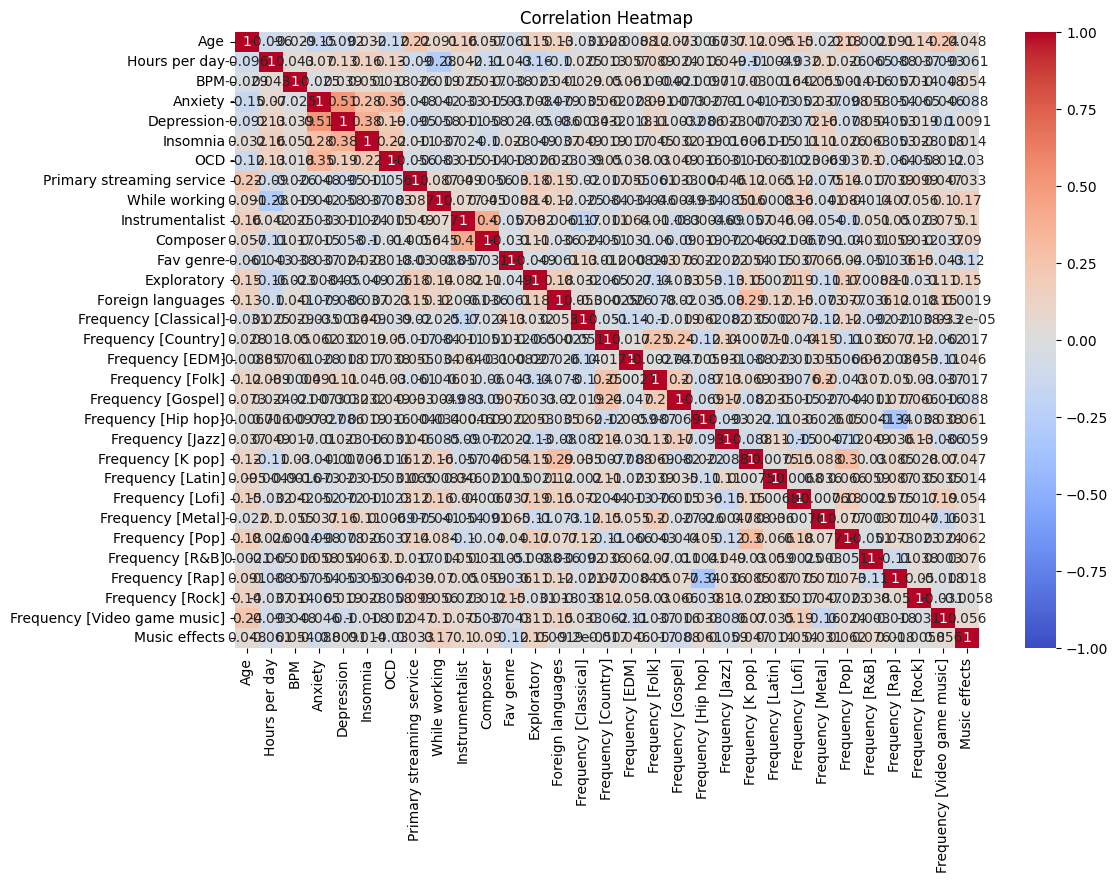

In [ ]:
# Correlation Analysis
corr = df_imputed.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

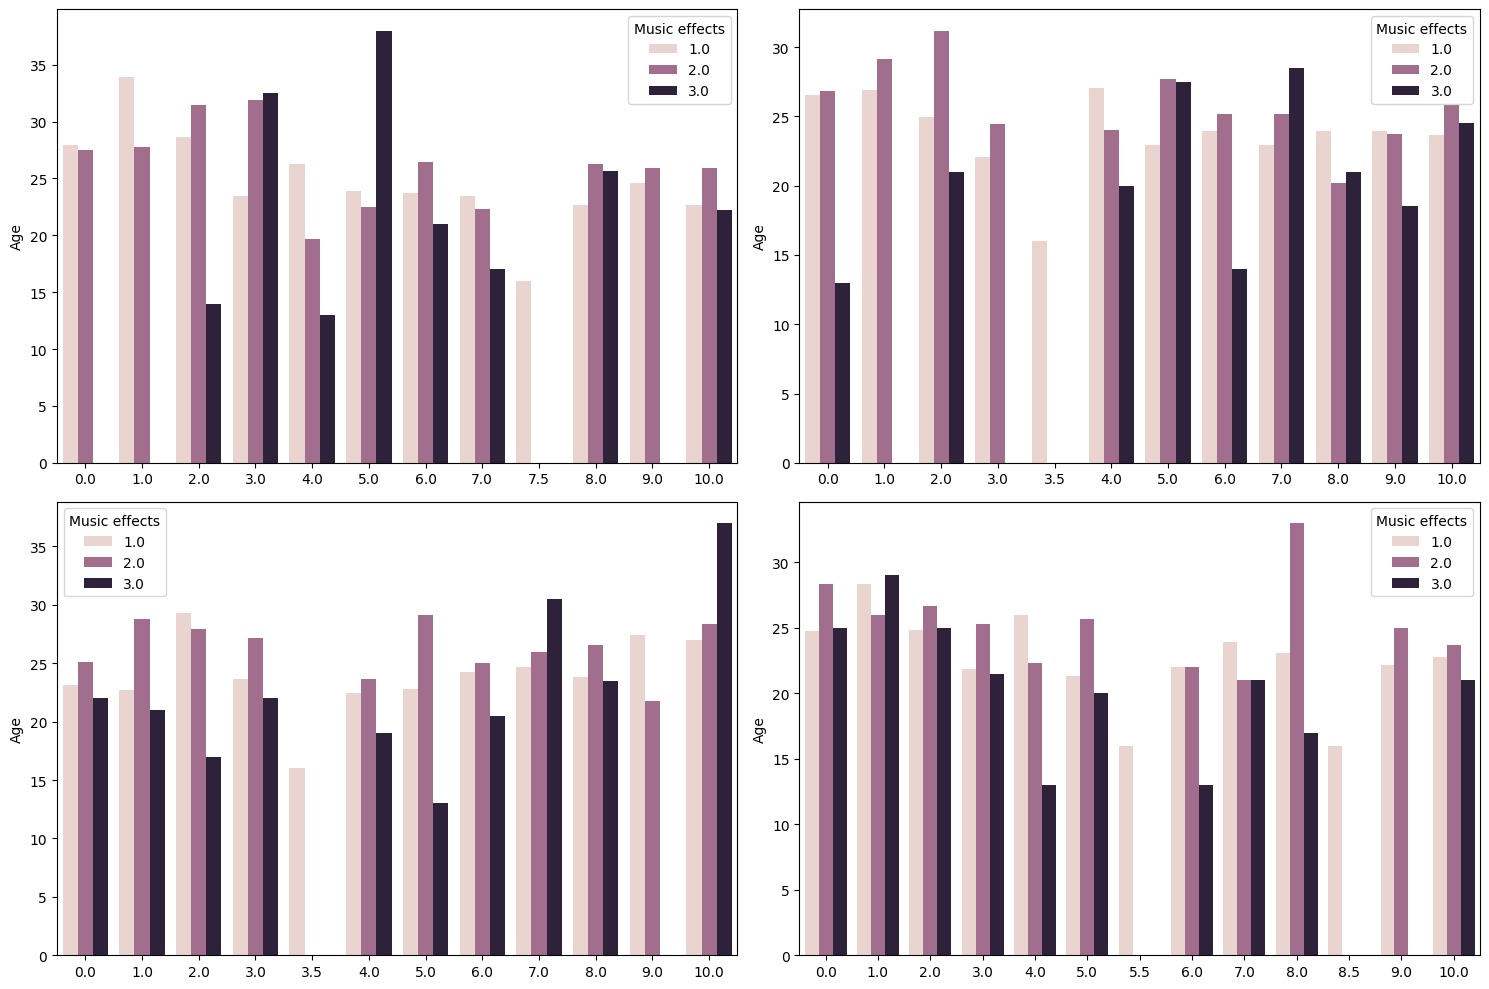

In [ ]:
# Visualization: Age vs. Mental Conditions with Music Effects
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.barplot(data=df_imputed, x="Anxiety", y="Age", hue='Music effects', errorbar=None, ax=axes[0, 0])
sns.barplot(data=df_imputed, x="Depression", y="Age", hue='Music effects', errorbar=None, ax=axes[0, 1])
sns.barplot(data=df_imputed, x="Insomnia", y="Age", hue='Music effects', errorbar=None, ax=axes[1, 0])
sns.barplot(data=df_imputed, x="OCD", y="Age", hue='Music effects', errorbar=None, ax=axes[1, 1])

for ax in axes.flat:
    ax.set_ylabel('Age')
    ax.set_xlabel('')

plt.tight_layout()
plt.show()


In [ ]:
print("In conclusion, the best fit model was the Random Forest model.")
print("The Logistic Regression model's validation accuracy score did not beat the Baseline Accuracy score and was overfit.")
print("The Decision Tree model's validation accuracy score beat the baseline accuracy score and was very overfit.")
print("However, the Random Forest model's validation accuracy score not only beat the baseline accuracy score, it was barely overfit. So the random forest improved by combining the predictions of multiple decision trees.")

In conclusion, the best fit model was the Random Forest model.
The Logistic Regression model's validation accuracy score did not beat the Baseline Accuracy score and was overfit.
The Decision Tree model's validation accuracy score beat the baseline accuracy score and was very overfit.
However, the Random Forest model's validation accuracy score not only beat the baseline accuracy score, it was barely overfit. So the random forest improved by combining the predictions of multiple decision trees.


# Conclusion
"In conclusion, the best fit model was the Random Forest model."
"The Logistic Regression model's validation accuracy score did not beat the Baseline Accuracy score and was overfit."
"The Decision Tree model's validation accuracy score beat the baseline accuracy score and was very overfit."
"However, the Random Forest model's validation accuracy score not only beat the baseline accuracy score, it was barely overfit. So the random forest improved by combining the predictions of multiple decision trees."

This project aimed to explore the impact of music therapy on various mental health conditions using a dataset from Kaggle. By preprocessing the data, establishing a baseline, and building multiple machine learning models, we were able to gain insights into the relationship between music and mental well-being. Among the models tested, the Random Forest classifier demonstrated the best performance, surpassing the baseline accuracy with minimal overfitting. This suggests that the Random Forest model's ability to combine the predictions of multiple decision trees makes it a robust choice for this type of analysis.

Our findings highlight the significant role music can play in mental health, reinforcing the therapeutic potential of music therapy. Future work could expand on this analysis by incorporating additional features or exploring different types of music and their specific effects on mental conditions. This study provides a strong foundation for further research into the benefits of music therapy and its application in mental health treatment.